# Part1: L2 Regularzition

In [12]:
import mynn as nn
from draw_tools.plot import plot

import numpy as np
from struct import unpack
import gzip
import matplotlib.pyplot as plt
import pickle

# fixed seed for experiment
np.random.seed(309)

train_images_path = r'.\dataset\MNIST\train-images-idx3-ubyte.gz'
train_labels_path = r'.\dataset\MNIST\train-labels-idx1-ubyte.gz'

with gzip.open(train_images_path, 'rb') as f:
        magic, num, rows, cols = unpack('>4I', f.read(16))
        train_imgs=np.frombuffer(f.read(), dtype=np.uint8).reshape(num, 28*28)
    
with gzip.open(train_labels_path, 'rb') as f:
        magic, num = unpack('>2I', f.read(8))
        train_labs = np.frombuffer(f.read(), dtype=np.uint8)


# choose 10000 samples from train set as validation set.
idx = np.random.permutation(np.arange(num))
# save the index.
with open('idx.pickle', 'wb') as f:
        pickle.dump(idx, f)
train_imgs = train_imgs[idx]
train_labs = train_labs[idx]
valid_imgs = train_imgs[:10000]
valid_labs = train_labs[:10000]
train_imgs = train_imgs[10000:]
train_labs = train_labs[10000:]

# normalize from [0, 255] to [0, 1]
train_imgs = train_imgs / train_imgs.max()
valid_imgs = valid_imgs / valid_imgs.max()

def train_model(nHidden=[128], lr=1.0, epochs=5, lambda_=0.0001):
    # 模型结构：输入层 + 隐藏层 + 输出层
    size_list = [train_imgs.shape[1]] + nHidden + [10]
    # 设置L2正则化强度，对每个线性层单独设置lambda值
    lambda_list = [lambda_] * (len(nHidden) + 1)  # 每层一个lambda
    
    # 初始化组件（关键修改：传入lambda_list给Model_MLP）
    model = nn.models.Model_MLP(size_list, 'ReLU', lambda_list)
    opt = nn.optimizer.MomentGD(init_lr=lr, model=model, mu=0.9)
    scheduler = nn.lr_scheduler.MultiStepLR(opt, milestones=[800, 2400, 4000], gamma=0.5)
    loss_fn = nn.op.MultiCrossEntropyLoss(model=model)
    
    # 修改RunnerM类（或创建子类）以支持L2正则化
    class RunnerWithL2(nn.runner.RunnerM):
        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            self.l2_loss_history = []  

        def compute_loss(self, X, y):
            # 计算交叉熵损失
            output = self.model(X)
            ce_loss = self.loss_fn(output, y)
            
            # 添加L2正则化损失
            l2_loss = self.model.compute_l2_loss()
            
            # 总损失 = 交叉熵损失 + L2正则化损失
            total_loss = ce_loss + l2_loss
            
            # 记录纯分类损失（不含L2）用于日志
            self.current_ce_loss = ce_loss
            self.current_l2_loss = l2_loss

            self.l2_loss_history.append(l2_loss)  
            
            return total_loss
        
        def log(self, iter_num, epoch_num, log_interval):
            # 扩展日志功能，显示L2损失
            if iter_num % log_interval == 0:
                print(f"Epoch {epoch_num}, Iteration {iter_num}: "
                      f"Train Loss = {self.current_loss:.4f} "
                      f"(CE: {self.current_ce_loss:.4f}, L2: {self.current_l2_loss:.4f}), "
                      f"Train Acc = {self.train_scores[-1]:.4f}, "
                      f"Val Acc = {self.dev_scores[-1]:.4f}")
    
    # 使用支持L2的Runner
    trainer = RunnerWithL2(
        model=model,
        optimizer=opt,
        metric=nn.metric.accuracy,
        loss_fn=loss_fn,
        batch_size=32,
        scheduler=scheduler
    )
    
    # 执行训练
    trainer.train(
        train_set=[train_imgs, train_labs],
        dev_set=[valid_imgs, valid_labs],
        num_epochs=epochs,
        log_iters=100,
        save_dir=f'./saved_models/l2_1e-4'
    )
    
    # 绘制训练曲线（增加L2损失曲线）
    _, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # 损失曲线
    axes[0].plot(trainer.train_loss, label='Total Loss')
    axes[0].plot([x - y for x, y in zip(trainer.train_loss, trainer.l2_loss_history)], 
                 label='CE Loss')
    axes[0].plot(trainer.dev_loss, label='Val Loss')
    axes[0].set_title('Loss Curve')
    axes[0].legend()
    
    # 准确率曲线
    axes[1].plot(trainer.train_scores, label='Train Acc')
    axes[1].plot(trainer.dev_scores, label='Val Acc')
    axes[1].set_title('Accuracy Curve')
    axes[1].legend()
    
    # # L2损失曲线
    # axes[2].plot(trainer.l2_loss_history, label='L2 Loss', color='red')
    # axes[2].set_title('L2 Regularization Loss')
    # axes[2].legend()
    
    # plt.tight_layout()
    # plt.show()
    
    return trainer

## $\lambda=0.0$

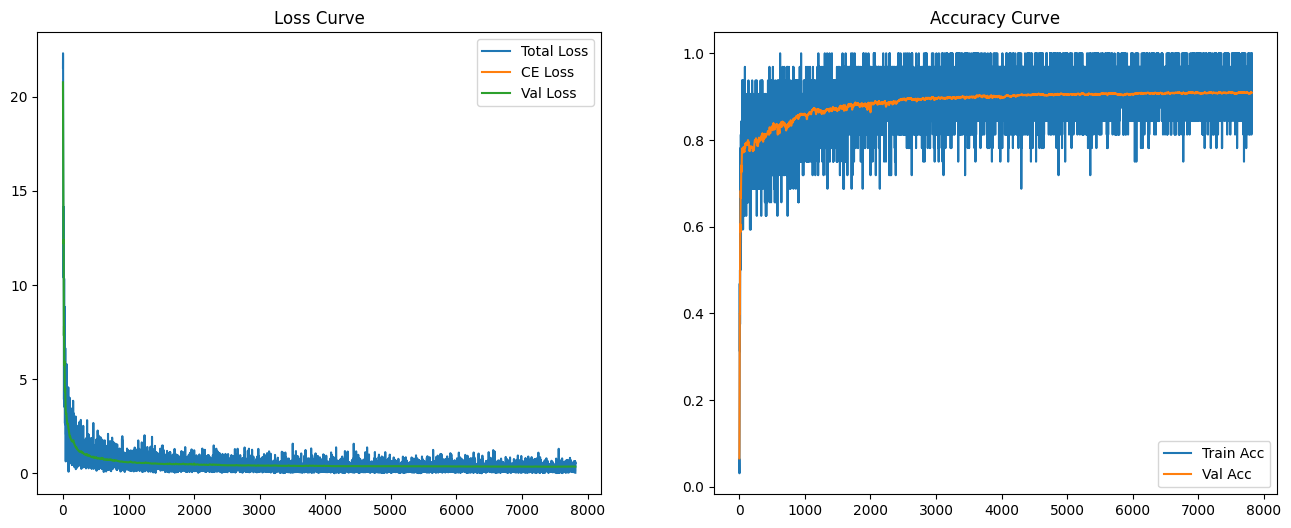

In [12]:
train1 = train_model(lambda_=0.0)

In [13]:
print("The best train accuracy:", max(train1.train_scores))
print("The best validation accuracy:", max(train1.dev_scores))

The best train accuracy: 1.0
The best validation accuracy: 0.911


## $\lambda=1e-2$

The best train accuracy: 0.84375
The best validation accuracy: 0.6404


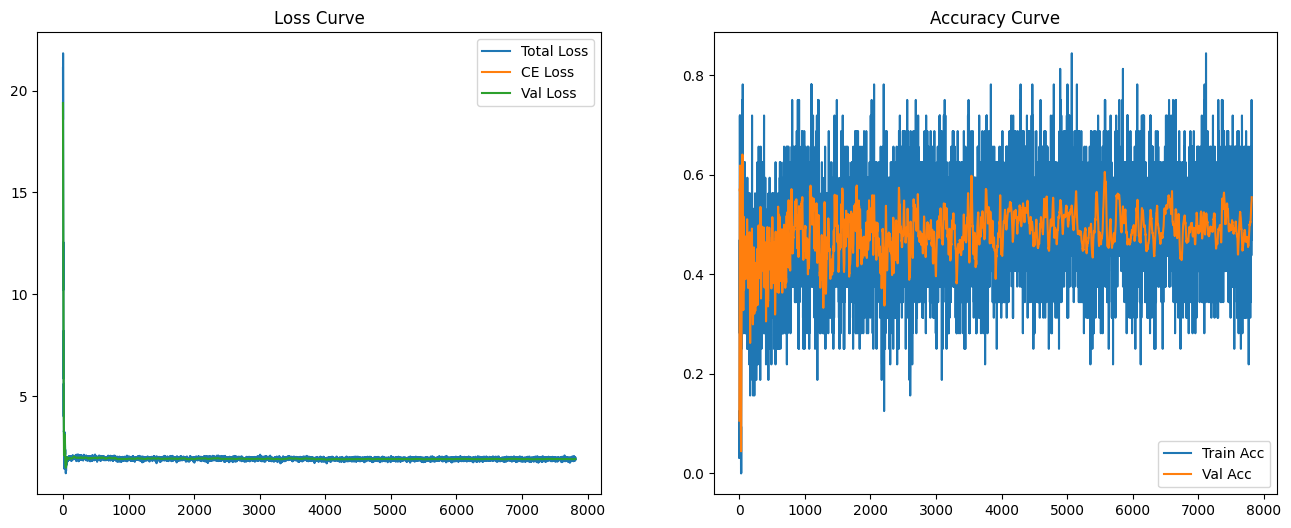

In [14]:
train2 = train_model(lambda_=0.01)
print("The best train accuracy:", max(train2.train_scores))
print("The best validation accuracy:", max(train2.dev_scores))

## $\lambda = 1e-3$

The best train accuracy: 1.0
The best validation accuracy: 0.8994


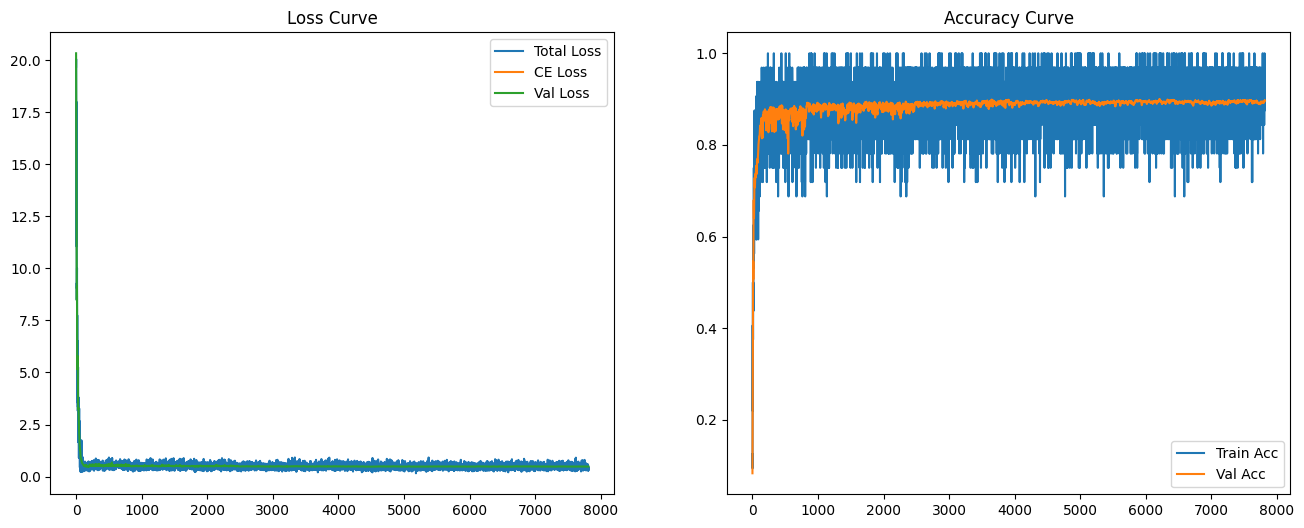

In [15]:
train3 = train_model(lambda_=0.001)
print("The best train accuracy:", max(train3.train_scores))
print("The best validation accuracy:", max(train3.dev_scores))

## $\lambda=1e-4$ 

The best train accuracy: 1.0
The best validation accuracy: 0.9584


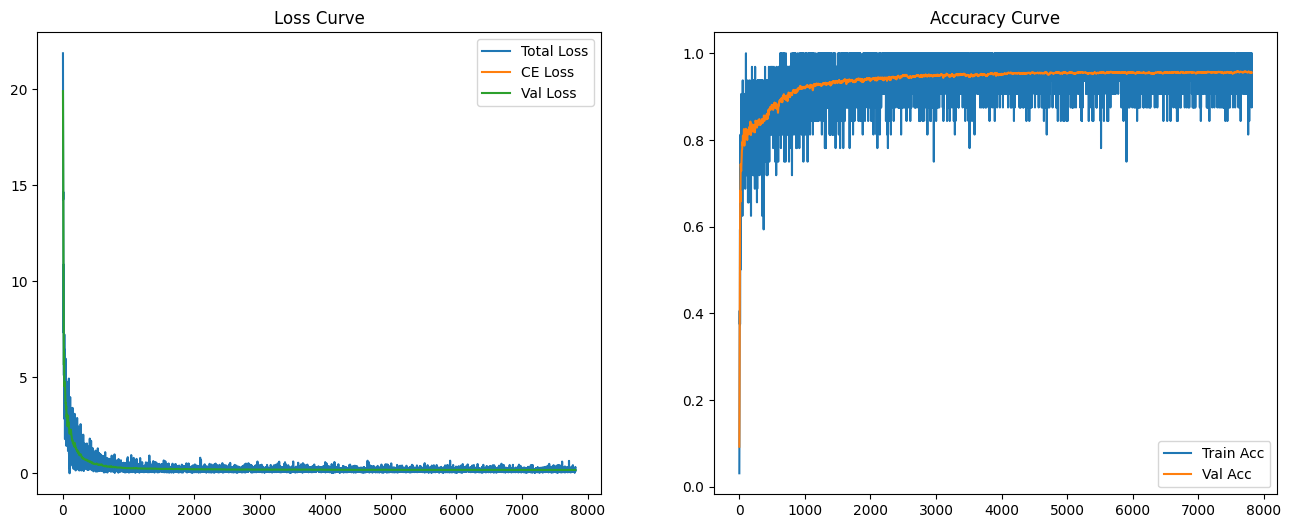

In [16]:
train4 = train_model(lambda_=0.0001)
print("The best train accuracy:", max(train4.train_scores))
print("The best validation accuracy:", max(train4.dev_scores))

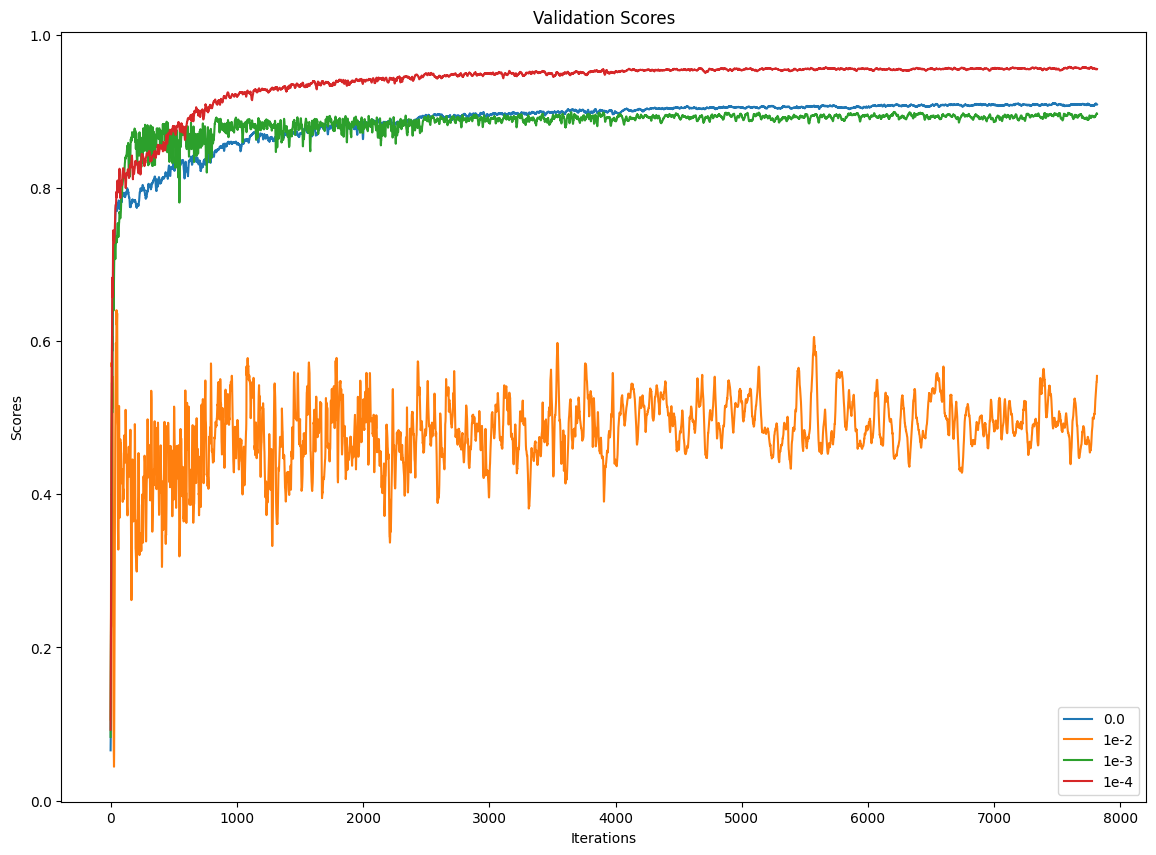

In [17]:
import matplotlib.pyplot as plt


# # 绘制validation scores图像
plt.figure(figsize=(14, 10))
plt.plot(train1.dev_scores, label='0.0')
plt.plot(train2.dev_scores, label='1e-2')
plt.plot(train3.dev_scores, label='1e-3')
plt.plot(train4.dev_scores, label='1e-4')
plt.title('Validation Scores')
plt.xlabel('Iterations')
plt.ylabel('Scores')
plt.legend()

# Part2: Dropout

In [14]:
import mynn as nn
from draw_tools.plot import plot

import numpy as np
from struct import unpack
import gzip
import matplotlib.pyplot as plt
import pickle

# fixed seed for experiment
np.random.seed(309)

train_images_path = r'.\dataset\MNIST\train-images-idx3-ubyte.gz'
train_labels_path = r'.\dataset\MNIST\train-labels-idx1-ubyte.gz'

with gzip.open(train_images_path, 'rb') as f:
        magic, num, rows, cols = unpack('>4I', f.read(16))
        train_imgs=np.frombuffer(f.read(), dtype=np.uint8).reshape(num, 28*28)
    
with gzip.open(train_labels_path, 'rb') as f:
        magic, num = unpack('>2I', f.read(8))
        train_labs = np.frombuffer(f.read(), dtype=np.uint8)


# choose 10000 samples from train set as validation set.
idx = np.random.permutation(np.arange(num))
# save the index.
with open('idx.pickle', 'wb') as f:
        pickle.dump(idx, f)
train_imgs = train_imgs[idx]
train_labs = train_labs[idx]
valid_imgs = train_imgs[:10000]
valid_labs = train_labs[:10000]
train_imgs = train_imgs[10000:]
train_labs = train_labs[10000:]

# normalize from [0, 255] to [0, 1]
train_imgs = train_imgs / train_imgs.max()
valid_imgs = valid_imgs / valid_imgs.max()

def train_model(nHidden=[128], lr=1.0, epochs=5, dropout_rates=[0.5]):
    # 模型结构：输入层 + 隐藏层 + 输出层
    size_list = [train_imgs.shape[1]] + nHidden + [10]
    lambda_list = [1e-4] * (len(nHidden) + 1)  # 每层一个lambda
    
    # 初始化组件
    model = nn.models.Model_MLP(size_list, 'ReLU', lambda_list, dropout_rates=dropout_rates)
    opt = nn.optimizer.MomentGD(init_lr=lr, model=model,mu=0.9)
    scheduler = nn.lr_scheduler.MultiStepLR(opt, milestones=[800, 2400, 4000], gamma=0.5)
    loss_fn = nn.op.MultiCrossEntropyLoss(model=model)
    
    # 训练运行器
    trainer = nn.runner.RunnerM(
        model=model,
        optimizer=opt,
        metric=nn.metric.accuracy,
        loss_fn=loss_fn,
        batch_size=32,
        scheduler=scheduler
    )
    
    # 执行训练
    trainer.train(
        train_set=[train_imgs, train_labs],
        dev_set=[valid_imgs, valid_labs],
        num_epochs=epochs,
        log_iters=100,
        save_dir=f'./saved_models/l2_1e-4_dropout'
    )
    
    # 绘制训练曲线
    _, axes = plt.subplots(1, 2, figsize=(12, 4))
    axes[0].plot(trainer.train_loss, label='Train Loss')
    axes[0].plot(trainer.dev_loss, label='Val Loss')
    axes[0].set_title('Loss Curve')
    axes[0].legend()
    
    axes[1].plot(trainer.train_scores, label='Train Acc')
    axes[1].plot(trainer.dev_scores, label='Val Acc')
    axes[1].set_title('Accuracy Curve')
    axes[1].legend()
    
    plt.show()
    
    return trainer

## dropout_rates=0.5, $\lambda=1e-4$

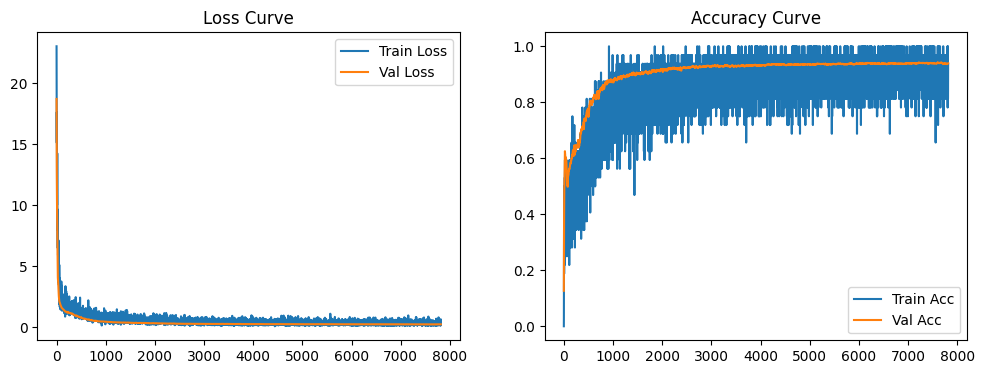

The best train accuracy: 1.0
The best validation accuracy: 0.9416


In [6]:
trainer1 = train_model(dropout_rates=[0.5])
print("The best train accuracy:", max(trainer1.train_scores))
print("The best validation accuracy:", max(trainer1.dev_scores))